<a href="https://colab.research.google.com/github/pintophilip/GPTs/blob/main/Session_Fine_tuning_large_language_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook will walk you through the process of instruction fine-tuning an LLM. The steps that we will take to perform this task are as follows:

1. Installing and importing required libraries
2. Comparing outputs from the two types of models
3. Exploring the fine-tuning data set
4. Data Preparation
5. Training and inference

## Problem Statement

> Fine tune a large language model using a data set that contains question answer pairs from the context of customer care.

## Data Description

The data set contains the following columns:
- flags: Contains tags for each entry in the data set
- instruction: A user request from the Customer Service domain
- category: The high-level semantic category for the intent
- intent: The intent corresponding to the user instruction
- response: An example expected response from the virtual assistant


We will mainly be using the *instruction*, *category*, and *response* columns for fine tuning.


# Installing and importing required libraries

In this section, we will install and import the required libraries. Please make sure that you are using the T4 GPU runtime before installing the libraries.

In [ ]:
# Installing required libraries
! pip install --upgrade pip lamini --disable-pip-version-check torch transformers==4.31.0 datasets --quiet accelerate==0.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.4/691.4 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.2/392.2 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

After installing the required libraries, we can now import the required methods from those libraries.

In [ ]:
import lamini
from google.colab import userdata
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
import pandas as pd
from datasets import Dataset

After importing required libraries, let's move on to comparing the outputs of instruction fine-tuned and non instruction fine-tuned models for the same input.

# Comparing outputs from the two types of models

To load the model easily, we are going to use the API provided by Lamini. Their `LLMEngine()` and `BasicModelRunner()` methods provide a simple interface for quickly loading LLMs.

Let's start by setting the API key for the Lamini API. Please make note of the use of the *secrets* functionality provided by Google Colab.


### Load via Secrets:

In [ ]:
from google.colab import userdata

In [ ]:
lamini.api_key = userdata.get('my_lamini_api_token')

In [ ]:
def load_api_key(file_path):

    try:
        with open(file_path, 'r') as file:
            api_key = file.read().strip()
        return api_key
    except FileNotFoundError:
        raise FileNotFoundError(f"API key file not found: {file_path}")
    except Exception as e:
        raise Exception(f"An error occurred while reading the API key file: {e}")


# Path to the text file containing the API key
file_path = '/content/api_key.txt'


# Load the API key
lamini_api_key = load_api_key(file_path)

if not lamini_api_key:
    raise ValueError("API key is empty or not found.")

#print(lamini_api_key)
# Use the API key
lamini.api_key = lamini_api_key

Let us now prompt the base model (a model that has not been instruction fine-tuned), `Llama-2-7b-hf`.

In [ ]:
#
non_chat_model = lamini.BasicModelRunner('meta-llama/Llama-2-7b-hf')


In [ ]:
print(non_chat_model.call("How to be a good data scientist?"))


How to be a good data scientist? Data science is a field that is growing rapidly. It is a field that is constantly changing and evolving. There are many different ways to be a good data scientist. In this article, we will discuss some of the ways that you can be a good data scientist.
Data science is a field that is constantly changing and evolving. There are many different ways to be a good data scientist. In this article, we will discuss some of the ways that you can be a good data scientist.
Data science is a field that is constantly changing and evolving. There are many different ways to be a good data scientist. In this article, we will discuss some of the ways that you can be a good data scientist.
Data science is a field that is constantly changing and evolving. There are many different ways to be a good data scientist. In this article, we will discuss some of the ways that you can be a good data scientist. Data science is a field that is constantly changing and evolving. There

Similarly, we can also look at the output of the chat fine-tuned Llama 2 model.

In [ ]:
chat_model = lamini.BasicModelRunner('meta-llama/Llama-2-7b-chat-hf')
print(chat_model.call("How to be a good data scientist?"))



Data science is a field that combines mathematics, statistics, computer science, and domain expertise in order to extract insights and knowledge from data. To be a good data scientist, one must have a strong foundation in these areas, as well as the ability to communicate complex ideas to non-technical stakeholders. Here are some key skills and traits that are important for data scientists to possess:

1. Strong analytical and problem-solving skills: Data scientists must be able to analyze complex data sets and identify patterns, trends, and insights. They must also be able to communicate their findings effectively to stakeholders.
2. Programming skills: Data scientists must be proficient in programming languages such as Python, R, or SQL, and be able to write efficient and well-structured code.
3. Statistical knowledge: Data scientists must have a strong understanding of statistical concepts such as hypothesis testing, regression analysis, and time series analysis.
4. Machine learni

You can clearly see the difference between the outputs of the two models.

Let's now move on to the fine tuning task. We will start by exploring the data set that we will use for fine-tuning.

# Exploring the fine-tuning data set

In this section, we will download and explore the data set that we will use for fine-tuning.

In [ ]:
data_path =  "https://raw.githubusercontent.com/bitext/customer-support-llm-chatbot-training-dataset/main/data/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv"



In [ ]:
df_q_a = pd.read_csv(data_path)

In [ ]:
df_q_a.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [ ]:
#instruction:
print("question: " +  df_q_a.iloc[2]["instruction"])

#response
print("answer: " + df_q_a.iloc[2]["response"] )

question: i need help cancelling puchase {{Order Number}}
answer: I can sense that you're seeking assistance with canceling your purchase with the purchase number {{Order Number}}. I apologize for any inconvenience caused, and I'm here to guide you through the process.

To cancel your purchase, please follow these steps:

1. Log into your account: Visit our {{Online Company Portal Info}} and sign in using your credentials.
2. Locate your order: Once logged in, navigate to the '{{Online Order Interaction}}' or '{{Online Order Interaction}}' section to find the purchase with the order number {{Order Number}}.
3. Initiate the cancellation: Upon finding your purchase, look for the option labeled '{{Online Order Interaction}}' and click on it to initiate the cancellation process.
4. Confirm the cancellation: Our system might ask for confirmation or feedback regarding the cancellation. Kindly provide the necessary information to complete the process.
5. Seek additional support: If you encoun

We have now explored the data set. Next let's explore the process of preparing the data for training.

# Data Preparation

The model that we are going to use for fine-tuning is the pythia-70m model. It has 70 million parameters and it a fairly small model compared to other LLMs. LLMs come with their own tokenizers which is what we are loading here in the next code cell.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Tokenizers created by the `Autotokenizer` object can be used to tokenize a single string or a sequence of strings. While training the model, it is likely that you want to tokenize all the strings that will be used for the training process. Whereas during inference, you might want to tokenize only a single string on which you are running the inference.

To demonstrate how tokenization works, we will first tokenize a single string and then put a few strings together in a sequence and examine what the output looks like.

In [ ]:
s = df_q_a['instruction'][0]

In [ ]:
print(df_q_a['instruction'][0])

question about cancelling order {{Order Number}}


In [ ]:
print(tokenizer(s))

{'input_ids': [19751, 670, 476, 68, 3485, 1340, 12033, 13921, 11057, 599], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


You can see that `encoded_string` contains two keys: `input_ids` and `attention_mask`. The values associated with `input_ids` are the actual tokens which will be sent into the model. Whereas the value associated with `attention_mask` tell the model which tokens to focus on and which tokens to ignore. You will learn about the attention mask later.

Now let's try to tokenize a list of strings as we might need to do for training our model on a large data set of strings.

In [ ]:
instructions =  df_q_a["instruction"][0]
responses = df_q_a["response"][0]

concatenated = [instructions, responses]

In [ ]:
len(concatenated)

2

In [ ]:
print(concatenated)

['question about cancelling order {{Order Number}}', "I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you."]


In [ ]:
print(tokenizer(concatenated) )

{'input_ids': [[19751, 670, 476, 68, 3485, 1340, 12033, 13921, 11057, 599], [42, 1849, 7192, 368, 452, 247, 1953, 5001, 14002, 272, 1340, 12033, 13921, 11057, 8503, 285, 309, 1353, 1060, 281, 2085, 368, 342, 253, 1491, 368, 878, 15, 7764, 564, 6386, 285, 1642, 634, 1953, 13, 285, 309, 1833, 513, 619, 1682, 281, 10073, 368, 15]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


You can see in this output that the values associated with `input_ids` and 'attention_mask` are lists of lists. The items in the first list are the tokens for the two strings that we tokenized and the items in the second list are their respective attention masks.

The need for attention masks arises because even though the length of the tokens accepted in an LLM is fixed and the size of our inputs will vary. You can also see this in the two lists of tokens that we have created above. As the size of the input strings were different, the lists of tokens are also of different sizes.

To handle this problem, we perform padding and truncation during tokenization to bring the token lists to the same size. Let's now move on to padding and truncation.



## Padding and truncation

Padding is used to bring the length of the list of tokens up to a uniform length by adding some placeholder tokens (if the length of the list of tokens is smaller than the required length). If the length of the list of tokens is longer than the required length, then perform truncation to bring it down to the required length.

Let's start by assigning the token to be used in padding as the end of sentence token.

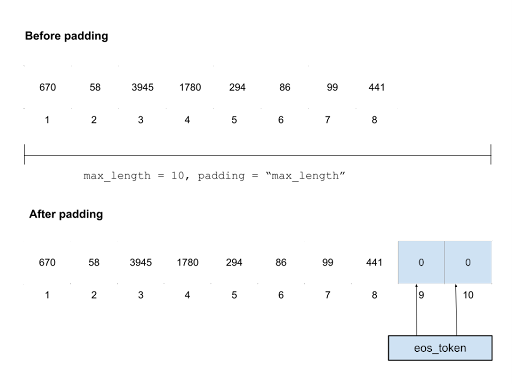

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
print(tokenizer.eos_token)

<|endoftext|>


By setting the value of padding to `True` we can increase the size of the shorter list of tokens up to the length of the longest token list.

In [ ]:
encoded_texts_longest = tokenizer(concatenated, padding = True)


print("Using padding: ", encoded_texts_longest["input_ids"])
print("Attention mask for this piece of text: ", encoded_texts_longest["attention_mask"])

Using padding:  [[19751, 670, 476, 68, 3485, 1340, 12033, 13921, 11057, 599, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [42, 1849, 7192, 368, 452, 247, 1953, 5001, 14002, 272, 1340, 12033, 13921, 11057, 8503, 285, 309, 1353, 1060, 281, 2085, 368, 342, 253, 1491, 368, 878, 15, 7764, 564, 6386, 285, 1642, 634, 1953, 13, 285, 309, 1833, 513, 619, 1682, 281, 10073, 368, 15]]
Attention mask for this piece of text:  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


Here, you can see that both the lists in `input_ids` are of the same length. But the padding token has been appended to the end of the shorter token list. You can also see that in the `attention_mask`, the values corresponding to the tokens that are irrelevant have been set to 0. You can read more about attention masks below.

**Attention mask**

An attention mask is used in transformer models to allow selective focus on valid data points and to prevent the model from attending to irrelevant information. Here's why it's necessary:

Handling Padding: Sequences are often padded to match the longest sequence's length before being fed into a transformer model because most neural network architectures expect inputs of consistent size. The attention mask indicates to the model which tokens are padding and should not be attended to.

Preserving Sequence Length: In tasks like translation or text generation, input sequences can vary significantly in length. The attention mask ensures that the self-attention mechanism doesn't consider these padded areas, maintaining the actual sequence length.

Improving Model Focus: During the self-attention phase, the model computes scores between all pairs of positions in the input sequence. The attention mask allows the model to focus only on relevant positions and ignore the rest, such as padded tokens or future tokens in tasks that require strict ordering (like causal language modeling).

Facilitating Different Tasks: Some tasks may require the model to only pay attention to certain parts of the input while ignoring others. For instance, in question-answering, the model should focus more on the portion of the text containing the answer.

Enhancing Model Efficiency: By ignoring unnecessary tokens, attention masks can reduce computational waste, making training and inference more efficient, especially for longer sequences.

Maintaining Context in Sequences: In causal or unidirectional language models, attention masks prevent the model from seeing future tokens, thus maintaining the flow of information in one direction. This is essential for preserving the autoregressive property where each token is predicted based on preceding tokens only.

In essence, attention masks are crucial for directing the transformer's attention mechanism to process sequences efficiently and effectively, respecting the context and structure of the input data.

You can also set the value of the `padding` parameter to 'max_length'. This way, you can specify the length of each padded string using the `max_length` parameter.

In [ ]:
#tokenizer

encoded_texts_longest = tokenizer(concatenated, max_length = 30, padding = 'max_length')
print("Using padding: ", encoded_texts_longest["input_ids"])
print("Attention mask for this piece of text: ", encoded_texts_longest["attention_mask"])
print("Length of the list of tokens:", len(encoded_texts_longest["input_ids"][0]))

Using padding:  [[19751, 670, 476, 68, 3485, 1340, 12033, 13921, 11057, 599, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [42, 1849, 7192, 368, 452, 247, 1953, 5001, 14002, 272, 1340, 12033, 13921, 11057, 8503, 285, 309, 1353, 1060, 281, 2085, 368, 342, 253, 1491, 368, 878, 15, 7764, 564, 6386, 285, 1642, 634, 1953, 13, 285, 309, 1833, 513, 619, 1682, 281, 10073, 368, 15]]
Attention mask for this piece of text:  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
Length of the list of tokens: 30


To reduce the length of the sequences, you can truncate them by setting the value of the `truncation` argument to `True`. This will truncate all the strings to the length specified by the `max_length` argument.

In [ ]:
encoded_texts_truncation = tokenizer(concatenated, max_length = 3, truncation = True)
print("Using truncation: ", encoded_texts_truncation)

Using truncation:  {'input_ids': [[19751, 670, 476], [42, 1849, 7192]], 'attention_mask': [[1, 1, 1], [1, 1, 1]]}


By default the tokenizer truncates from the right-hand side, but you can specify the direction from which to truncate by setting the value of the `truncation_side` attribute.

In [ ]:
#Left Truncation

tokenizer.truncation_side = "left"
encoded_texts_truncation_left = tokenizer(concatenated, max_length=3, truncation=True)

print("Using left-side truncation: ", encoded_texts_truncation_left)

Using left-side truncation:  {'input_ids': [[13921, 11057, 599], [10073, 368, 15]], 'attention_mask': [[1, 1, 1], [1, 1, 1]]}


You can do a combination of both padding and truncation as required by the problem at hand.

In [ ]:
#Using both Padding & Truncation
encoded_texts_both = tokenizer(concatenated, max_length=3, truncation=True, padding = True)

print("Using both padding and truncation: ", encoded_texts_both["input_ids"])

Using both padding and truncation:  [[13921, 11057, 599], [10073, 368, 15]]


You have now seen how to pad and truncate strings while performing tokenization. To prepare the data set to be sent into the LLM, we need to use a prompt template and send our input-output pairs into that prompt template.

Let's see how we can do that for one record.

## Using prompt templates

Before tokenizing our question answer pairs and using them for training, we need to wrap them in a prompt so that the model can understand the relationship between the two. We will do that here.

From our data set, we will only use the instruction and response columns.

In [ ]:
df_q_a

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...
...,...,...,...,...,...
26867,BL,I am waiting for a rebate of {{Refund Amount}}...,REFUND,track_refund,Thank you for sharing your situation regarding...
26868,BIL,how to see if there is anything wrong with my ...,REFUND,track_refund,Ensuring the accuracy of your restitution is o...
26869,BLQZ,I'm waiting for a reimbjrsement of {{Currency ...,REFUND,track_refund,"Firstly, I genuinely understand the importance..."
26870,BL,I don't know what to do to see my reimbursemen...,REFUND,track_refund,I've understood you're unsure about how to che...


We will choose a subset of our data set. You should try training on the whole data set.

In [ ]:
#Subset the cancel_order

df_q_a = df_q_a[df_q_a['intent'] == "cancel_order"]

In [ ]:
list_of_entries = []
for i in range(0, len(df_q_a)):
  entry = {
      'question': f"### Below is an instruction that describes a task. Write a response that appropriately completes the request. \nQuestion:\n{df_q_a.iloc[i]['instruction']}\n\n### Answer:",
      'answer': df_q_a.iloc[i]['response']
  }
  list_of_entries.append(entry)

In [ ]:
list_of_entries[0]

{'question': '### Below is an instruction that describes a task. Write a response that appropriately completes the request. \nQuestion:\nquestion about cancelling order {{Order Number}}\n\n### Answer:',
 'answer': "I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you."}

Let's now tokenize this.

In [ ]:
text = list_of_entries[0]['question'] + list_of_entries[0]['answer']

tokenized_inputs = tokenizer(
    text,
    return_tensors = 'np',
    padding = True
)

print(tokenized_inputs["input_ids"])

[[ 4118 23195   310   271  9775   326  8631   247  4836    15 19566   247
   2380   326 20420 29141   253  2748    15   209   187 23433    27   187
  19751   670   476    68  3485  1340 12033 13921 11057   599   187   187
   4118 37741    27    42  1849  7192   368   452   247  1953  5001 14002
    272  1340 12033 13921 11057  8503   285   309  1353  1060   281  2085
    368   342   253  1491   368   878    15  7764   564  6386   285  1642
    634  1953    13   285   309  1833   513   619  1682   281 10073   368
     15]]


Let's write a function that can do tokenization for any entry.

In [ ]:
def tokenize_function(entry):
    # Ensure the question and answer are strings
    question = str(entry['question'])
    answer = str(entry['answer'])

    # Concatenate the question and answer
    text = question + " " + answer

    # Tokenize the concatenated text
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        padding=True,
        max_length=2048
    )
    return tokenized_inputs

Now let's perform tokenization on the list of entries that we have prepared.

In [ ]:
finetuning_dataset = Dataset.from_pandas(pd.DataFrame(list_of_entries))

In [ ]:
finetuning_dataset['question'][1]

'### Below is an instruction that describes a task. Write a response that appropriately completes the request. \nQuestion:\ni have a question about cancelling oorder {{Order Number}}\n\n### Answer:'

In [ ]:
finetuning_dataset['answer'][1]

"I've been informed that you have a question about canceling order {{Order Number}}. I'm here to assist you! Please go ahead and let me know what specific question you have, and I'll provide you with all the information and guidance you need. Your satisfaction is my top priority."

In [ ]:
tokenized_dataset = finetuning_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1,
    drop_last_batch=True
)

print(tokenized_dataset)

Map:   0%|          | 0/998 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 998
})


By default, the trainer that we will use from the `transformers` library looks for a column named `labels`. Therefore, we will copy the `input_ids` column to create a new column called `labels`.

In [ ]:
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

In [ ]:
tokenized_dataset

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 998
})

Finally, we need to perform train-test split on this data set.

## Train/test split

In [ ]:
split_dataset = tokenized_dataset.train_test_split(test_size = 0.1, shuffle = True, seed = 123)
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 898
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})


In [ ]:
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

print(train_dataset)
print(test_dataset)


Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 898
})
Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})


Now that our data is ready, we can move on to training the model.

# Training and inference

Let's now train the model

## Training the model


In [ ]:
global_config = None

In [ ]:
model_name = "EleutherAI/pythia-70m"

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [ ]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Define the function 'inference' which takes a piece of text, a model, a tokenizer,
  # and optional arguments for the maximum number of input and output tokens.

  # Tokenize the input text.
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",  # Return the result as PyTorch tensors.
          truncation=True,  # Truncate the text to fit the max input length.
          max_length=max_input_tokens  # Set the maximum token length for the input text.
  )

  # Create an attention mask which is 1 for real tokens and 0 for padding tokens.
  attention_mask = (input_ids != tokenizer.pad_token_id).int()

  # Assign the model's device to a variable. This ensures that tensor operations
  # are performed on the same device where the model is loaded (CPU/GPU).
  device = model.device

  # Generate tokens using the model, passing in the processed inputs.
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),  # Move input tokens to the same device as the model.
    max_length=max_output_tokens,  # Set the maximum token length for the output text.
    attention_mask=attention_mask,  # Provide the attention mask for the model to ignore padding.
    pad_token_id=tokenizer.eos_token_id  # Specify the end-of-sequence token ID for padding if needed.
  )

  # Decode the generated tokens back into text, ignoring special tokens like padding or end-of-sequence.
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Remove the initial prompt from the generated text to obtain only the model's output.
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  # Return the final generated text, which is the answer from the model without the prompt.
  return generated_text_answer

In [ ]:
test_text = test_dataset[0]['question']

print("Question input (test):", test_text)
print(f"Correct answer from the dataset: {test_dataset[0]['answer']}")
print("Model's answer: ")
print(inference(test_text, base_model, tokenizer))

Question input (test): ### Below is an instruction that describes a task. Write a response that appropriately completes the request. 
Question:
i need assistance with canceling purchase {{Order Number}}

### Answer:
Correct answer from the dataset: I've grasped that you're seeking assistance with canceling purchase {{Order Number}}, and I'm here to guide you through the process. Cancelling a purchase is important, and we want to ensure a smooth experience for you. Here's what you need to do:

1. Access Your Account: Start by logging in to our {{Online Company Portal Info}}.
2. Locate Your Purchase: Once logged in, navigate to the '{{Online Order Interaction}}' or '{{Online Order Interaction}}' section.
3. Identify the Purchase: Look for the purchase associated with the order number {{Order Number}}. Click on it for more details.
4. Initiate the Cancellation: You'll find the option to '{{Online Order Interaction}}' linked with your purchase. Please select that.
5. Complete the Process: 

In [ ]:
trained_model_name = f"q_a_{num_train_epochs}_steps"
output_dir = trained_model_name

In [ ]:
# Initialize the TrainingArguments with various hyperparameters and settings for training.
training_args = TrainingArguments(

  # Specify the learning rate for the optimizer.
  learning_rate=1.0e-5,

  # Define the number of epochs for training (complete passes over the dataset).
  num_train_epochs=5,

  # Indicate the maximum number of training steps (batches of data) to perform.
  # If set to a value other than -1, it will override num_train_epochs.
  #max_steps = 5,

  # Set the size of each training batch that is processed per device (e.g., per GPU).
  per_device_train_batch_size=1,

  # Designate the directory where the model checkpoints will be saved during training.
  output_dir=output_dir,

  # If set to True, the content of the output directory will be overwritten.
  overwrite_output_dir=False,

  # Determines how often the evaluation phase is run during training (after this many steps).
  eval_steps=120,

  # Sets how often to save a model checkpoint (after this many steps).
  save_steps=120,

  # Number of steps to perform learning rate warmup, which can improve training stability.
  warmup_steps=1,

  # Set the size of each evaluation batch that is processed per device.
  per_device_eval_batch_size=1,

  # Determines the evaluation strategy to use during training.
  # "Steps" means to evaluate after a certain number of training steps.
  evaluation_strategy="steps",

  # Indicates the logging strategy to use, which determines how often to log metrics.
  # "Steps" means to log after a certain number of training steps.
  logging_strategy="steps",

  # Configures how often to log training metrics (after this many steps).
  logging_steps=1,

  # Specifies the optimizer to use during training. 'adafactor' is a memory-efficient optimizer.
  optim="adafactor",

  # Number of steps for which gradients are accumulated before performing a backpropagation update.
  gradient_accumulation_steps=4,

  # Enables or disables gradient checkpointing, which can save memory at the cost of slower backward passes.
  gradient_checkpointing=False,

  # If set to True, the model with the best evaluation metric will be loaded at the end of training.
  load_best_model_at_end=True,

  # Limits the total number of model checkpoints to save, to manage storage space.
  save_total_limit=1,

  # Indicates which metric to use for identifying the 'best' model during training.
  metric_for_best_model="eval_loss",

  # When set to False, a lower metric is considered better for 'metric_for_best_model'.
  greater_is_better=False
)

In [ ]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

training_output = trainer.train()

save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)
finetuned_slightly_model.to(torch.device("cpu"))

Step,Training Loss,Validation Loss
120,0.712800,0.722098
240,0.699800,0.636969
360,0.533300,0.594893
480,0.439800,0.570939
600,0.485200,0.552870
720,0.370200,0.551096
840,0.600400,0.535013
960,0.346000,0.533626
1080,0.428900,0.530296


Saved model to: q_a_50_steps/final


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

Now that the model is trained, we can perform inference on the model.

### Inference on finetuned model

Output from the foundation model.

In [ ]:
test_question = test_dataset[0]['question']
print("Question input (test):", test_question)

print("Finetuned slightly model's answer: ")
print(inference(test_question, finetuned_slightly_model, tokenizer))

Question input (test): ### Below is an instruction that describes a task. Write a response that appropriately completes the request. 
Question:
i need assistance with canceling purchase {{Order Number}}

### Answer:
Finetuned slightly model's answer: 
 Cancel the purchase with the order number {{Order Number}}. Your satisfaction is our priority, and I'm here to guide you through the cancellation process. Here's what you need to do to cancel your purchase:

### Contact Customer Support: Contact Customer Support Customer Support Customer Support Customer Support Customer Support


In [ ]:
test_answer = test_dataset[0]['answer']
print("Target answer output (test):", test_answer)

Target answer output (test): I've grasped that you're seeking assistance with canceling purchase {{Order Number}}, and I'm here to guide you through the process. Cancelling a purchase is important, and we want to ensure a smooth experience for you. Here's what you need to do:

1. Access Your Account: Start by logging in to our {{Online Company Portal Info}}.
2. Locate Your Purchase: Once logged in, navigate to the '{{Online Order Interaction}}' or '{{Online Order Interaction}}' section.
3. Identify the Purchase: Look for the purchase associated with the order number {{Order Number}}. Click on it for more details.
4. Initiate the Cancellation: You'll find the option to '{{Online Order Interaction}}' linked with your purchase. Please select that.
5. Complete the Process: Our system may prompt you for additional information or feedback to finalize the cancellation.

If you encounter any difficulties or have any questions during the process, our dedicated team is available during {{Custome

Next steps:
1. Train the model using the whole data set
2. Tune the number of epochs needed to minimize the validation error
3. Increase the number of tokens in the model.
4. Use a larger model for fine-tuning
5. Use parameter efficient fine-tuning techniques like LoRA and qLoRA